In [135]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plots
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import io
import os
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers  import L2, L1
from tensorboard.plugins.hparams import api as hp
from google.colab import drive

In [136]:
dataset, dataset_info = tfds.load('malaria', with_info=True,
                                  as_supervised=True,
                                  shuffle_files = True,
                                  split=['train'])

In [137]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [138]:

TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )
#print(list(train_dataset.take(1).as_numpy_iterator()),
#      list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

# Dataset Visualization

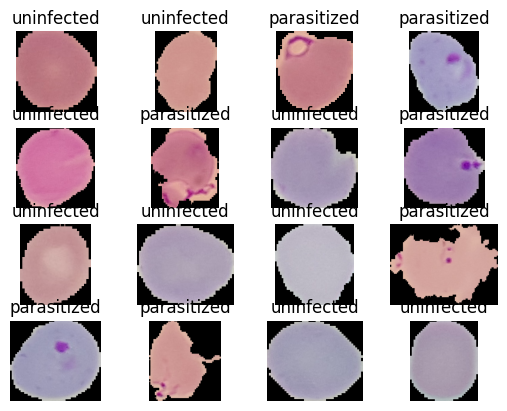

In [139]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features["label"].int2str(label))
  plt.axis("off")

# Data Preprocessig

In [140]:
IM_SIZE= 224

def resizing_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [141]:
train_dataset = train_dataset.map(resizing_rescale)
val_dataset = val_dataset.map(resizing_rescale)
test_dataset = test_dataset.map(resizing_rescale)


In [142]:
for image,label in train_dataset.take(1):
  print(image,label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [143]:
train_dataset = (
    train_dataset
    .shuffle(buffer_size = 8, reshuffle_each_iteration = True)
  ).batch(32).prefetch(tf.data.AUTOTUNE)


In [144]:
val_dataset = (
    val_dataset
    .shuffle(buffer_size = 8, reshuffle_each_iteration = True)
  ).batch(32).prefetch(tf.data.AUTOTUNE)


In [145]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [146]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [147]:
model = tf.keras.Sequential(
    [
        InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

    Conv2D(
    filters=6,
    kernel_size=3,
    strides=1,
    padding='valid',
    activation="relu"
),
        BatchNormalization()
        ,
   Conv2D(
    filters=16,
    kernel_size=3,
    strides=1,
    padding='valid',
    activation="relu"

),
        BatchNormalization()
        ,
        MaxPool2D(
    pool_size=2,
    strides=2,
        ),

        Flatten(),

        Dense(1000, activation="relu"),
        BatchNormalization(),
         Dense(100, activation="relu"),
         BatchNormalization(),
         Dense(1, activation="sigmoid")
          ]
)

model.summary()



Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_12 (Bat  (None, 222, 222, 6)      24        
 chNormalization)                                                
                                                                 
 conv2d_21 (Conv2D)          (None, 220, 220, 16)      880       
                                                                 
 batch_normalization_13 (Bat  (None, 220, 220, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 110, 110, 16)     0         
 g2D)                                                            
                                                     

In [148]:
y_true = [0, 1, 0, 0]
y_pred = [0.6, 0.51, 0.94,1]
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
bce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0227046>

In [149]:
from keras.losses import MeanAbsoluteError
model.compile(optimizer=Adam(learning_rate=0.1),
              loss=MeanAbsoluteError(),
              metrics="accuracy"
              )


In [ ]:
history = model.fit(train_dataset, epochs=10, verbose=1)

Epoch 1/10
689/689 [==============================] - 58s 79ms/step - loss: 0.4785 - accuracy: 0.5216
Epoch 2/10
689/689 [==============================] - 58s 85ms/step - loss: 0.5001 - accuracy: 0.4999
Epoch 3/10
689/689 [==============================] - 54s 78ms/step - loss: 0.5000 - accuracy: 0.5000
Epoch 4/10
689/689 [==============================] - 53s 77ms/step - loss: 0.5001 - accuracy: 0.4999
Epoch 5/10
689/689 [==============================] - 53s 77ms/step - loss: 0.5001 - accuracy: 0.4999
Epoch 6/10
689/689 [==============================] - 53s 77ms/step - loss: 0.5001 - accuracy: 0.4999
Epoch 7/10
689/689 [==============================] - 55s 80ms/step - loss: 0.5000 - accuracy: 0.5000
Epoch 8/10
221/689 [========>.....................] - ETA: 36s - loss: 0.5021 - accuracy: 0.4979

In [ ]:
history

In [ ]:
import matplotlib.pyplot as plt

# Check if 'val_loss' is in history.history
if 'val_loss' in history.history:
    # Plot both training and validation loss
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')

    plt.title('model_loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()
else:
    # If 'val_loss' is not found, only plot training loss
    plt.plot(history.history['loss'])
    plt.title('model_loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()


In [ ]:
val_dataset

# Model Evaluation and Testing

In [ ]:
test_dataset = test_dataset.batch(1)

In [ ]:
test_dataset

In [ ]:
model.evaluate(test_dataset)